In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as sc_stats
import tabulate

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

from odf.opendocument import load as odf_load

In [11]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  'font.size': 16,
  'grid.alpha': 0.25})

## Function declarations

### Read `ods` to `DataFrame`

In [12]:
def read_ods(filename, columns=None):
  if columns is None:
    df = pd.read_excel(filename, engine="odf", header=0)
  elif isinstance(columns, list):
    df = pd.read_excel(filename, engine="odf", header=0,
                       usecols=columns)
  else:
    key_arr = (k for k in columns.keys())
    df = pd.read_excel(filename, engine="odf", header=0,
                      usecols=key_arr)
    df = df.rename(columns=columns)
  return df

### Get multiple regression coefficients

In [13]:
def get_multiple_regress_coeff(df, n_vars=2):
  
  if isinstance(df, pd.DataFrame):
    num_of_samples = len(df)
    X_arr = np.zeros((num_of_samples, n_vars))
    Y = df["Y"].to_numpy()

    for i in range(n_vars):
      key = f"X_{i+1}"
      X_arr[:, i] = df[key].to_numpy()

    regress = LinearRegression().fit(X_arr, Y)
    df["hat_Y"] = regress.intercept_ + X_arr.dot(regress.coef_) 
  
  elif isinstance(df, np.ndarray):
    Y = df[:, 0]
    X_arr = df[:, 1:]


    regress = LinearRegression().fit(X_arr, Y)
    Y_hat = regress.intercept_ + X_arr.dot(regress.coef_)
    df = np.column_stack([df, Y_hat])

  return regress, df


### Get ANOVA table

In [14]:
def get_ANOVA_table(df, n_vars=2):
  data_struct = np.zeros((len(df), 1+n_vars))
  data_struct[:, 0] = df['Y']
  for i in range(n_vars):
    key = f"X_{i+1}"
    data_struct[:, i+1] = df[key]
  
  # -- compute regression intercept and coefficients
  regress, _ = get_multiple_regress_coeff(df, n_vars=n_vars)

  num_of_samples = len(df)
  hat_Y =  regress.intercept_ + data_struct[:,1:].dot(regress.coef_)
  meanY = data_struct[:, 0].mean()
  
  SST = ((data_struct[:, 0] - meanY)**2).sum()
  SSR = ((hat_Y - meanY)**2).sum()
  SSE = ((data_struct[:, 0] - hat_Y)**2).sum()
  anova_sumSq = np.array([SSR, SSE, SST])
  anova_dof = np.array([n_vars, num_of_samples - n_vars - 1, num_of_samples - 1], dtype=int)
  anova_meanSq = (anova_sumSq/anova_dof)[:2]
  anova_F_score = anova_meanSq[0] / anova_meanSq[1]
  anova_p_value = sc_stats.f.sf(anova_F_score, anova_dof[0], anova_dof[1])   # sf is a survival function (1 - cdf)

  # -- compute R_sq (coefficient of determination)
  R_sq = SSR / SST

  # -- create ANOVA table (with F-score and its p-value)
  data = [
    ["Regression",     anova_dof[0], anova_sumSq[0], f"{anova_meanSq[0]:.3f}", f"{anova_F_score:.3f}", f"{anova_p_value:.4f}"],
    ["Residual error", anova_dof[1], anova_sumSq[1], f"{anova_meanSq[1]:.3f}", "", ""],
    ["Total",          anova_dof[2], anova_sumSq[2], "", "", ""]] 
  anova_table = tabulate.tabulate(data, tablefmt='html', 
    headers=["Source", "d.o.f", "sumSq", "meanSq", "F-score", "p-value"], 
    floatfmt=[None, ".0f", ".3f", "s", "s", "s"])
  
  print(f"Analyis of Variance")
  display(anova_table)


  return anova_table, [SST, SSR, SSE] 

### Get Durbin-Watson statistics 

In [15]:
def get_durbin_watson(df, var_names=None):
  df_dw = df.copy()
  
  name_replacement = {}
  name_replacement[var_names[0]] = "Y"
  predictors = []
  for i, predictor_i in enumerate(var_names[1:]):
    name_replacement[predictor_i] = f"X_{i+1}"
    predictors.append(f"X_{i+1}")

  df_dw = df_dw.rename(columns=name_replacement)
  num_of_samples = len(df_dw)
  num_of_vars = len(predictors)

  data_struct = np.zeros((num_of_samples, 1+num_of_vars))
  data_struct[:, 0] = df_dw["Y"]

  for i, predictor in enumerate(predictors):
    data_struct[:, i+1] = df_dw[predictor]

  # -- compute regression coefficients
  regress, _ = get_multiple_regress_coeff(data_struct, n_vars=len(predictors))

  b_arr = [regress.intercept_] + regress.coef_.tolist()

  df_dw["hat_Y"] =  b_arr[0] + data_struct[:,1:].dot(b_arr[1:])
  df_dw["e_t"] = df_dw["Y"] - df_dw["hat_Y"]
  df_dw["e_t - e_tM1"] = df_dw["e_t"] - df_dw["e_t"].shift(1)
  df_dw["(e_t - e_tM1)^2"] = df_dw["e_t - e_tM1"]**2
  df_dw["e_tSq"] = df_dw["e_t"]**2

  dw_stats = df_dw["(e_t - e_tM1)^2"].sum() / df_dw['e_tSq'].sum()

  return df_dw, dw_stats

### Durbin-Watson critical value

In [16]:
df_dw_crit_05 = pd.read_excel("../durbin-watson-test-bounds-alpha-0_05.ods",
  header=[1, 2], index_col=0)
df_dw_crit_01 = pd.read_excel("../durbin-watson-test-bounds-alpha-0_01.ods", 
  header=[1, 2], index_col=0)

## Load the data

### Sales and income data

In [17]:
filename = "07-table-01-reynolds-metals-sales.ods"

df = read_ods(filename)

df

,Year,Sales Y_t,Income X_t
0,1986,295,273.4
1,1987,400,291.3
2,1988,390,306.9
3,1989,425,317.1
4,1990,547,336.1
5,1991,555,349.4
6,1992,620,362.9
7,1993,720,383.9
8,1994,880,402.8
9,1995,1050,437.0


## Fitted line plot (simple linear regression) 

In [32]:
df_fit = df.copy()

df_fit = df_fit.rename(columns=
  {"Sales Y_t": "Y",
   "Income X_t": "X_1"})
df_fit

# compute fitted regression line
regress, _ = get_multiple_regress_coeff(df_fit, n_vars=1)

# compute coefficient of determination
anova_table, [SST, SSR, SSE] = get_ANOVA_table(df_fit, n_vars=1)

num_of_samples = len(df)
n_vars = 1
s_yxs = np.sqrt(SSE/(num_of_samples - n_vars - 1))
rSq = SSR/SST
adj_rSq = 1 - (1 - rSq)*(num_of_samples-1)/(num_of_samples-n_vars-1)

print(f"  s_yxs: {s_yxs:>7.3f}")
print(f"    rSq: {rSq*100:>5.1f}%  ")
print(f"adj_rSq: {adj_rSq*100:>5.1f}%  ")


Analyis of Variance


Source,d.o.f,sumSq,meanSq,F-score,p-value
Regression,1,21061160.215,21061160.215,181.016,0.0000
Residual error,19,2210645.595,116349.768,,
Total,20,23271805.810,,,


  s_yxs: 341.101
    rSq:  90.5%  
adj_rSq:  90.0%  


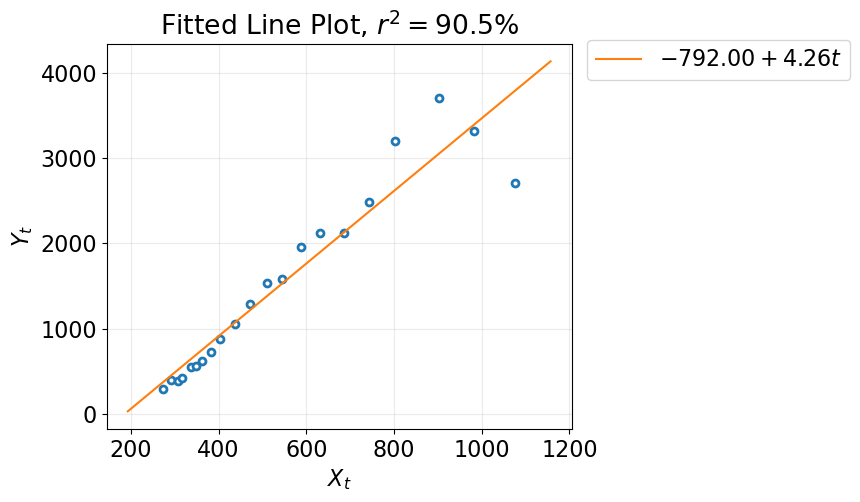

In [19]:
fig, ax = plt.subplots(figsize=(6, 5))

ax.plot(df_fit["X_1"], df_fit["Y"], 
  marker='o', markersize=5, markerfacecolor='white',
  linestyle='None', markeredgewidth=2) 

b0 = regress.intercept_
b1 = regress.coef_[0]

data_t_min = df_fit["X_1"].min()
data_t_max = df_fit["X_1"].max()
t_offset = 0.1*(data_t_max - data_t_min)
t_regress = np.linspace(data_t_min - t_offset, data_t_max + t_offset)
regress_label = r"${:.2f} + {:.2f}t$".format(b0, b1) \
  if b1 > 0 else r"${:.2f}{:.2f}t$".format(b0, b1)

ax.plot(t_regress, b0 + b1*t_regress, 
  linestyle='-',
  label=regress_label) 

ax.set_xlabel(r"$X_t$")
ax.set_ylabel(r"$Y_t$")
ax.set_title(r"Fitted Line Plot, $r^2={:.1f}$%".format(rSq*100))

ax.legend(loc="upper left", bbox_to_anchor=[1.01, 1.04])
ax.grid("on")
plt.show(fig)



## Durbin-Watson statistic

In [35]:
var_names = ["Sales Y_t", "Income X_t"]
df_dw, dw_stats = get_durbin_watson(df, var_names=var_names)

print(f"dw_stats = {dw_stats:.2f}")
df_dw

dw_stats = 0.87


,Year,Y,X_1,hat_Y,e_t,e_t - e_tM1,(e_t - e_tM1)^2,e_tSq
0,1986,295,273.4,371.360185,-76.360185,NaN,NaN,5.830878e+03
1,1987,400,291.3,447.527672,-47.527672,28.832513,8.313138e+02,2.258880e+03
2,1988,390,306.9,513.908275,-123.908275,-76.380603,5.833996e+03,1.535326e+04
3,1989,425,317.1,557.310977,-132.310977,-8.402702,7.060540e+01,1.750619e+04
4,1990,547,336.1,638.159147,-91.159147,41.151830,1.693473e+03,8.309990e+03
5,1991,555,349.4,694.752866,-139.752866,-48.593719,2.361350e+03,1.953086e+04
6,1992,620,362.9,752.197618,-132.197618,7.555248,5.708177e+01,1.747621e+04
7,1993,720,383.9,841.556122,-121.556122,10.641496,1.132414e+02,1.477589e+04
8,1994,880,402.8,921.978776,-41.978776,79.577347,6.332554e+03,1.762218e+03
9,1995,1050,437.0,1067.505482,-17.505482,24.473294,5.989421e+02,3.064419e+02


## Durbin-Watson test

The *Durbin-Watson test* can be used to determine whether positive lag 1
autocorrelation is present.

$$
  \begin{gather*}
    \text{If } DW > d_\mathrm{U}, \text{ conclude } H_0: \rho = 0. \\
    \text{If } DW < d_\mathrm{L}, \text{ conclude } H_1: \rho > 0.
  \end{gather*}
$$

If $DW$ lies within the lower and upper bounds $(d_\mathrm{L} \leq DW \leq d_\mathrm{U})$,
the test is inconclusive.

In [36]:
def test_statistic_dw(dw_stats, n_samples, k_predictors, significance_lvl_arr):
  for significance_lvl in significance_lvl_arr:
    if abs(significance_lvl - 0.05) < 1e-4:
      d_lower = df_dw_crit_05.xs(n_samples).xs(f"k = {k_predictors}").xs("d_L")
      d_upper = df_dw_crit_05.xs(n_samples).xs(f"k = {k_predictors}").xs("d_U")
      
    elif abs(significance_lvl - 0.01) < 1e-4:
      d_lower = df_dw_crit_01.xs(n_samples).xs(f"k = {k_predictors}").xs("d_L")
      d_upper = df_dw_crit_01.xs(n_samples).xs(f"k = {k_predictors}").xs("d_U")

    test_status = "" 
    if dw_stats > d_upper:
      test_status = "null hypothesis accepted"
    elif dw_stats < d_lower:
      test_status = "null hypotesis rejected"
    else:
      test_status = "inconclusive"

    print(f"significance_lvl: {significance_lvl}")
    print(f"  durbin-watson statistics: {dw_stats:.2f}")
    print(f"  durbin-watson critical values (d_L, d_U): {d_lower, d_upper}")
    print(f"  conclusion: {test_status}\n")


    

In [37]:
significance_lvl = [0.05, 0.01]
n_samples = len(df_dw) 
k_predictors = 1

test_statistic_dw(dw_stats, n_samples, k_predictors, significance_lvl)

significance_lvl: 0.05
  durbin-watson statistics: 0.87
  durbin-watson critical values (d_L, d_U): (1.22, 1.42)
  conclusion: null hypotesis rejected

significance_lvl: 0.01
  durbin-watson statistics: 0.87
  durbin-watson critical values (d_L, d_U): (0.97, 1.16)
  conclusion: null hypotesis rejected



When using significance level $0.01$, DW falls below $d_L$, 
the null hypothesis rejected,    
and it is concluded that the errros
are positively correlated ($\rho > 0$).    
The regression model should
be modified before it is used for forecasting